В данном задании вам нужно применить методы машинного обучения для предсказания оценок на данных из первой части. Все пункты, помеченные '(!)' нельзя пропускать - дальнейшие пункты без них невозможны (остальные можно сначала пропустить и вернуться к ним позже)

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Загрузите датасет, с которым работали в первой части. Если не помните, используйте функцию ниже.

In [133]:
def get_df_name(name):
    return 'student-mat.csv' if sum(ord(c) for c in name) % 2 else 'student-por.csv'

df_name = get_df_name('Орлова Елена Геннадьевна')
print(df_name)

student-mat.csv


In [134]:
df = pd.read_csv('student-mat.csv', sep = ';')
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


В качестве целевого признака мы будем использовать финальную оценку G3. Оценки G1 и G2 мы не будем использовать в
качестве признаков - они слишком сильно коррелируют с ответом.
Извлеките из остальных данных признаки:
* **(1 балл)(!)** Извлеките только числовые признаки
* **(1 балл)** Извлеките также бинарные и категориальные признаки

Ниже указано несколько инструментов, которые могут быть полезны (изучите самостоятельно):
* `pd.get_dummies`
* `sklearn.preprocessing.OneHotEncoder`
* `pd.concat`
* `np.hstack`

In [135]:
df = df.drop(['G1', 'G2'], 1)

In [136]:
num_features = np.vstack([df['age'].values, 
                              df['Medu'].values, 
                              df['Fedu'].values,
                              df['traveltime'].values, 
                              df['studytime'].values,
                              df['failures'].values,
                              df['famrel'].values,
                              df['freetime'].values,
                              df['goout'].values,
                              df['Dalc'].values,
                              df['Walc'].values,
                              df['health'].values,
                              df['absences'].values]).T
bin_features = np.vstack([(df['schoolsup'] == 'yes').values,
                             (df['famsup'] == 'yes').values,
                             (df['paid'] == 'yes').values,
                             (df['activities'] == 'yes').values,
                             (df['nursery'] == 'yes').values,
                             (df['higher'] == 'yes').values,
                             (df['internet'] == 'yes').values,
                             (df['romantic'] == 'yes').values]).T
categ_features = np.hstack((pd.get_dummies(df['school']), 
                                  pd.get_dummies(df['sex']),
                                  pd.get_dummies(df['address']),
                                  pd.get_dummies(df['famsize']),
                                  pd.get_dummies(df['Pstatus']),
                                  pd.get_dummies(df['Mjob']),
                                  pd.get_dummies(df['Fjob']),
                                  pd.get_dummies(df['reason'])))

features = np.hstack((num_features, bin_features, categ_features))

**(1 балл)(!)** Проверьте, насколько хорошо работает линейная регрессия (`sklearn.linear_model.LinRegressionression`) на этих данных с помощью кросс-валидации (`sklearn.cross_validation.cross_val_score`). Для этого в функцию `cross_val_score` нужно передать аргумент `scoring='mean_squared_error'` (учтите, что по техническим причинам функция будет возвращать значения MSE с минусом). Выведите результат в терминах RMSE.

In [137]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
from sklearn.linear_model import Lasso, Ridge

In [138]:
def LinReg(features):
    modelLR = LinearRegression()
    scores = cross_val_score(modelLR, features, target, scoring = 'mean_squared_error', cv = 5).mean()
    RMSE = math.sqrt(math.fabs(scores))
    print('RMSE for linear regression =', RMSE)
    return RMSE
    
score_LinReg = LinReg(features)

RMSE for linear regression = 4.477540895905259


In [161]:
def Error_on_cross_validation(features, model):
    scores = cross_val_score(model, features, target.ravel(), scoring = 'mean_squared_error', cv = 5).mean()
    return math.sqrt(math.fabs(scores))

def alpha_score(features, class_reg):
    best_alpha = 0.1
    model = class_reg(alpha = 0.1)
    best_score = Error_on_cross_validation(features, model)
    for i in range(500):
        Alpha = 0.1 + 0.1*i
        model = class_reg(alpha = Alpha)
        score = Error_on_cross_validation(features, model)
        if score < best_score:
            best_alpha = Alpha
            best_score = score
    print(class_reg, "\nРегрессор выдал наименьшую ошибку =  ", best_score, "при alpha = ", best_alpha)
    return best_score

In [140]:
score_Lasso = alpha_score(features, Lasso)
score_Ridge = alpha_score(features, Ridge)

<class 'sklearn.linear_model.coordinate_descent.Lasso'> 
Регрессор выдал наименьшую ошибку =   4.359230224079379 при alpha =  0.2
<class 'sklearn.linear_model.ridge.Ridge'> 
Регрессор выдал наименьшую ошибку =   4.313112565696272 при alpha =  50.00000000000001


In [141]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def depth_score(features, class_reg):
    best_depth = 1
    model = class_reg(max_depth = best_depth)
    best_score = Error_on_cross_validation(features, model)
    for depth in range(1, 60):
        model = class_reg(max_depth = depth)
        score = Error_on_cross_validation(features, model)
        if score < best_score:
            best_depth = depth
            best_score = score
    print(class_reg, "\nРегрессор выдал наименьшую ошибку = ", best_score , "при depth", best_depth)
    return best_score, best_depth 

score_DecTree, depth_DecTree = depth_score(features, DecisionTreeRegressor)
score_RandForest, depth_RandForest = depth_score(features, RandomForestRegressor)

<class 'sklearn.tree.tree.DecisionTreeRegressor'> 
Регрессор выдал наименьшую ошибку =  4.439805358325869 при depth 2
<class 'sklearn.ensemble.forest.RandomForestRegressor'> 
Регрессор выдал наименьшую ошибку =  4.127851717336538 при depth 3


In [142]:
def Number_of_Trees(features, depth):
    best_number = 2
    model = RandomForestRegressor(n_estimators = best_number, max_depth = depth)
    best_score = Error_on_cross_validation(features, model)
    print("Попробуем изменить количество деревьев при depth =", depth)
    for trees in range(2, 20):
        model = RandomForestRegressor(n_estimators = trees, max_depth = depth)
        score = Error_on_cross_validation(features, model)
        if score < best_score:
            best_number = trees
            best_score = score
    print(RandomForestRegressor, "\nРегрессор выдал наименьшую ошибку = ", best_score, "при depth = ", \
          depth, ", кол-во деревьев ", best_number)
    return best_score

score_RandForest = Number_of_Trees(features, depth_RandForest)

Попробуем изменить количество деревьев при depth = 3
<class 'sklearn.ensemble.forest.RandomForestRegressor'> 
Регрессор выдал наименьшую ошибку =  4.137347600831678 при depth =  3 , кол-во деревьев  4


In [143]:
from sklearn.neighbors import KNeighborsRegressor

def neighbors(features):
    best_neighbors = 1
    model = KNeighborsRegressor(n_neighbors = best_neighbors)
    best_score = Error_on_cross_validation(features, model)

    for neighbors in range(1, 30):
        model = KNeighborsRegressor(n_neighbors = neighbors)
        score = Error_on_cross_validation(features, model)
        if score < best_score:
            best_neighbors = neighbors
            best_score = score
    print(KNeighborsRegressor, "\nРегрессор выдал наименьшую ошибку = ", best_score, "при количестве соседей = ",\
       best_neighbors)
    return best_score

score_Neigh = neighbors(features)

<class 'sklearn.neighbors.regression.KNeighborsRegressor'> 
Регрессор выдал наименьшую ошибку =  4.343267985428593 при количестве соседей =  12


Подведем итоги:

In [144]:
print('\t\t\t\t    RMSE\t\t\t')
print('Линйная регрессия:\t\t', score_LinReg)
print('L1 - регуляризация:\t\t', score_Lasso)
print('L2 - регуляризация:\t\t', score_Ridge)
print('Решающее дерево:\t\t', score_DecTree)
print('Случайный лес:\t\t\t', score_RandForest)
print('Метод ближайших соседей:\t', score_Neigh)

				    RMSE			
Линйная регрессия:		 4.477540895905259
L1 - регуляризация:		 4.359230224079379
L2 - регуляризация:		 4.313112565696272
Решающее дерево:		 4.439805358325869
Случайный лес:			 4.137347600831678
Метод ближайших соседей:	 4.343267985428593


*Видим, что Random Forest дает наименьшую ошибку*

Теперь ваша задача - подобрать наилучший способ обучения. Для этого можно применять разные приемы, за проверку каждого из них вы получаете баллы (код проверки для неудачных вариантов нужно оставить):
* **(1 балл)** Шкалирование признаков (`sklearn.preprocessing.StandardScaler()` и др.)
* **(2 балла)** Подбор оптимальных параметров перебором
* **(2 балла)** Отбор признаков с помощью, например, корреляции Пирсона

Отмасштабируем признаки и посмотрим, какие ошибки на них будут выдавать уже реализованные методы:

In [145]:
from sklearn.preprocessing import scale
scaled_features = scale(features)

Sscore_LinReg = LinReg(scaled_features)

RMSE for linear regression = 43750310949605.625


In [146]:
Sscore_Lasso = alpha_score(scaled_features, Lasso)

<class 'sklearn.linear_model.coordinate_descent.Lasso'> 
Регрессор выдал наименьшую ошибку =   4.3667950337425445 при alpha =  0.5


In [147]:
Sscore_Ridge = alpha_score(scaled_features, Ridge)

<class 'sklearn.linear_model.ridge.Ridge'> 
Регрессор выдал наименьшую ошибку =   4.390297355957568 при alpha =  50.00000000000001


In [148]:
Sscore_DecTree, SCdepth_DecTree = depth_score(scaled_features, DecisionTreeRegressor)

<class 'sklearn.tree.tree.DecisionTreeRegressor'> 
Регрессор выдал наименьшую ошибку =  4.439805358325869 при depth 2


In [149]:
Sscore_RandForest, SCdepth_RandForest  = depth_score(scaled_features, RandomForestRegressor)

<class 'sklearn.ensemble.forest.RandomForestRegressor'> 
Регрессор выдал наименьшую ошибку =  4.150168809020295 при depth 3


In [150]:
Sscore_RandForest = Number_of_Trees(scaled_features, SCdepth_RandForest)

Попробуем изменить количество деревьев при depth = 3
<class 'sklearn.ensemble.forest.RandomForestRegressor'> 
Регрессор выдал наименьшую ошибку =  4.106594364193614 при depth =  3 , кол-во деревьев  13


In [151]:
Sscore_Neigh = neighbors(scaled_features)

<class 'sklearn.neighbors.regression.KNeighborsRegressor'> 
Регрессор выдал наименьшую ошибку =  4.438522631457127 при количестве соседей =  29


In [152]:
print('\t\t\t\t\t\t     RMSE')
print('\t\t\t\t до масштабирования\t\t после масштабирования')
print('Линйная регрессия:\t\t', score_LinReg, '\t\t', Sscore_LinReg)
print('L1 - регуляризация:\t\t', score_Lasso, '\t\t', Sscore_Lasso)
print('L2 - регуляризация:\t\t', score_Ridge, '\t\t', Sscore_Ridge)
print('Решающее дерево:\t\t', score_DecTree, '\t\t', Sscore_DecTree)
print('Случайный лес:\t\t\t', score_RandForest, '\t\t', Sscore_RandForest)
print('Метод ближайших соседей:\t', score_Neigh, '\t\t', Sscore_Neigh)

						     RMSE
				 до масштабирования		 после масштабирования
Линйная регрессия:		 4.477540895905259 		 43750310949605.625
L1 - регуляризация:		 4.359230224079379 		 4.3667950337425445
L2 - регуляризация:		 4.313112565696272 		 4.390297355957568
Решающее дерево:		 4.439805358325869 		 4.439805358325869
Случайный лес:			 4.137347600831678 		 4.106594364193614
Метод ближайших соседей:	 4.343267985428593 		 4.438522631457127


Random Forest дает наименьшую ошибку и при масштабированных признаках.

Корреляция Пирсона

<Container object of 45 artists>

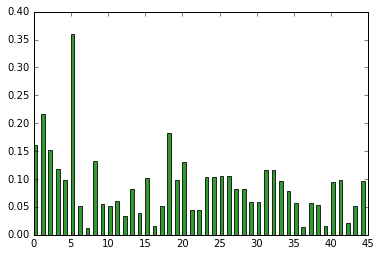

In [153]:
import scipy as sp
from scipy.stats import pearsonr

def coefficient_pearson():
    arr_coefficient = []
    arr_index = []
    for i in range(45):
        corr_coefficient = sp.stats.pearsonr(pd.DataFrame(scaled_features)[i], target.ravel())[0]
        arr_coefficient.append(corr_coefficient)
        if math.fabs(corr_coefficient) < 0.1:
            arr_index.append(i)
    return arr_coefficient, arr_index

y, ind_del = coefficient_pearson()
y = np.absolute(y)
index = np.arange(45)
bar_width = 0.5
plt.bar(index, y, bar_width, alpha = 0.8, color='green')

Попробуем выкинуть признаки, для которых коэффициент корреляции с целевым признаком стремится к нулю (например, <0.1)

In [154]:
dependent_features = scaled_features
dependent_features = sp.delete(dependent_features, np.array(ind_del), 1) 
Dscore_LinReg = LinReg(dependent_features)

RMSE for linear regression = 4.283580482011444


In [155]:
Dscore_Lasso = alpha_score(dependent_features, Lasso)

<class 'sklearn.linear_model.coordinate_descent.Lasso'> 
Регрессор выдал наименьшую ошибку =   4.269172735396986 при alpha =  0.1


In [156]:
Dscore_Ridge = alpha_score(dependent_features, Ridge)

<class 'sklearn.linear_model.ridge.Ridge'> 
Регрессор выдал наименьшую ошибку =   4.2682674672130165 при alpha =  50.00000000000001


In [157]:
Dscore_DecTree, DEPdepth_DecTree = depth_score(dependent_features, DecisionTreeRegressor)

<class 'sklearn.tree.tree.DecisionTreeRegressor'> 
Регрессор выдал наименьшую ошибку =  4.434529278472216 при depth 1


In [158]:
Dscore_RandForest, DEPdepth_RandForest  = depth_score(dependent_features, RandomForestRegressor)

<class 'sklearn.ensemble.forest.RandomForestRegressor'> 
Регрессор выдал наименьшую ошибку =  4.359915528266878 при depth 1


In [159]:
Dscore_Neigh = neighbors(dependent_features)

<class 'sklearn.neighbors.regression.KNeighborsRegressor'> 
Регрессор выдал наименьшую ошибку =  4.367869694672207 при количестве соседей =  18


Сравним результаты для масштабированных признаков до и после отбора признаков

In [160]:
print('\t\t\t\t\t\t     RMSE')
print('\t\t\t\t до отбора признаков\t\t после отбора признаков')
print('Линйная регрессия:\t\t', SCscore_LinReg, '\t\t', Dscore_LinReg)
print('L1 - регуляризация:\t\t', SCscore_Lasso, '\t\t', Dscore_Lasso)
print('L2 - регуляризация:\t\t', SCscore_Ridge, '\t\t', Dscore_Ridge)
print('Решающее дерево:\t\t', SCscore_DecTree, '\t\t', Dscore_DecTree)
print('Случайный лес:\t\t\t', SCscore_RandForest, '\t\t', Dscore_RandForest)
print('Метод ближайших соседей:\t', SCscore_Neigh, '\t\t', Dscore_Neigh)

						     RMSE
				 до отбора признаков		 после отбора признаков
Линйная регрессия:		 43750310949605.625 		 4.283580482011444
L1 - регуляризация:		 4.3667950337425445 		 4.269172735396986
L2 - регуляризация:		 4.390297355957568 		 4.2682674672130165
Решающее дерево:		 4.439805358325869 		 4.434529278472216
Случайный лес:			 4.106594364193614 		 4.359915528266878
Метод ближайших соседей:	 4.438522631457127 		 4.367869694672207


Видим, что ошибка после исключения признаков, почти не коррелирующих с цеоевой переменной, только увеличилась. Значит, масштабирования признаков достаточно.

Подведем итог: на заданных данных лучше всего работает Ranadom Forest, масштабирование признаков помогло уменьшить ошибку, в отличие от отбора признаков, мало коррелирующих с целевой переменной.